In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ir_measures import RR, R, nDCG, read_trec_run
import ir_datasets
import json
import gzip

In [109]:
qrels_dl19 = list(ir_datasets.load('msmarco-passage/trec-dl-2019').qrels)
qrels_devs = list(ir_datasets.load('msmarco-passage/dev/small').qrels)
df = []
for ncells in [1, 2, 4, 8]:
  for centroid_score_threshold in [0.3, 0.4, 0.45, 0.5, 0.6]:
    for ndocs in [256, 1024, 4096, 8192]:
        id = f'plaid.ncells-{ncells}.cst-{centroid_score_threshold}.ndocs-{ndocs}'
        latency = float(open(f'results/devs.{id}.time').read())
        res_dl19 = json.load(gzip.open(f'results/dl19.{id}.run.gz.measures.json.gz'))
        # res_dl20 = json.load(gzip.open(f'results/dl20.{id}.run.gz.measures.json.gz'))
        res_devs = json.load(gzip.open(f'results/devs.{id}.run.gz.measures.json.gz'))
        # res_dl20 = json.load(gzip.open(f'results/dl20.{id}.run.gz.measures.json.gz'))
        # run_devs = list(read_trec_run(f'results/devs.{id}.run.gz'))
        df.append({
            'ncells': ncells,
            'cst': centroid_score_threshold,
            'ndocs': ndocs,
            'devs_latency': latency,
            # 'devs_rr': (RR@10).calc_aggregate(qrels_devs, run_devs),
            # 'devs_r1k': (R@1000).calc_aggregate(qrels_devs, run_devs),
            'dl19_ndcg10': res_dl19['avg']['nDCG@10'],
            'dl19_ndcg1k': res_dl19['avg']['nDCG@1000'],
            'dl19_r1k': res_dl19['avg']['R(rel=2)@1000'],
            'dl19_rbo99': res_dl19['avg']['RBO(p=0.99)'],
            # 'dl20_ndcg10': res_dl20['avg']['nDCG@10'],
            # 'dl20_ndcg1k': res_dl20['avg']['nDCG@1000'],
            # 'dl20_r1k': res_dl20['avg']['R(rel=2)@1000'],
            # 'dl20_rbo99': res_dl20['avg']['RBO(p=0.99)'],
            'devs_rr10': res_devs['avg']['RR@10'],
            'devs_r1k': res_devs['avg']['R@1000'],
            'devs_rbo99': res_devs['avg']['RBO(p=0.99)'],
        })
df = pd.DataFrame(df)
df = df[df.ncells!=100]
dl19_exh = json.load(gzip.open('results/dl19.exhuastive.run.gz.measures.json.gz'))['avg']
devs_exh = json.load(gzip.open('results/devs.exhuastive.run.gz.measures.json.gz'))['avg']

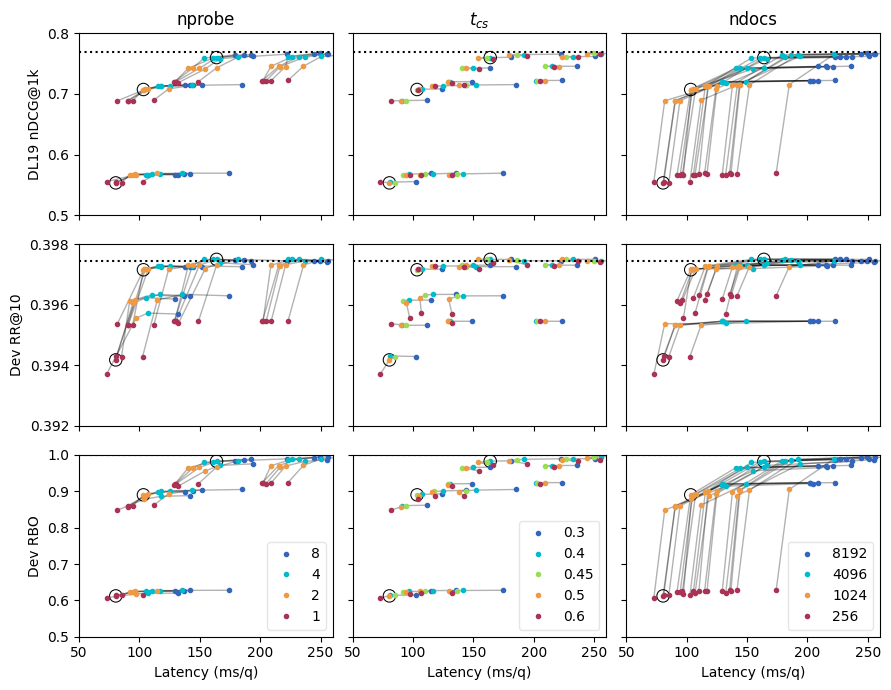

In [129]:
fig, axs = plt.subplots(3, 3, figsize=(9, 7), sharex='col', sharey='row')

for row, measure in enumerate(['dl19_ndcg1k', 'devs_rr10', 'devs_rbo99']):
    for col, factor in enumerate(['ncells', 'cst', 'ndocs']):
        ax = axs[row][col]
        others = {'ncells', 'cst', 'ndocs'}
        others.discard(factor)
        for key, sub_df in df.groupby(list(others)):
            ax.plot(sub_df.devs_latency, sub_df[measure], c='k', lw=1, alpha=0.3)
            # ax.set_xscale('log')
        d = df.groupby(factor)
        if factor == 'cst':
            d = list(reversed(list(d)))
        for i, (key, sub_df) in reversed(list(enumerate(d))):
            if len(d) == 5:
                c = ['#a35', '#e94', '#9d5', '#0bc', '#36b'][i]
            elif len(d) == 4:
                c = ['#a35', '#e94', '#0bc', '#36b'][i]
            ax.plot(sub_df.devs_latency, sub_df[measure], '.', label=f'{key}', c=c)
        if row == 0:
            ax.set_title({'cst': '$t_{cs}$', 'ncells': 'nprobe'}.get(factor, factor))
        for i, (ncells, cst, ndocs) in enumerate([(1, .5, 256), (2, .45, 1024), (4, .4, 4096)]):
            subdf = df[(df.ncells==ncells) & (df.cst==cst) & (df.ndocs==ndocs)]
            ax.scatter(subdf.devs_latency, subdf[measure], s=80, facecolors='none', edgecolors='k', ls='-', lw=0.75, zorder=-1000)
            # ax.scatter(subdf.devs_latency, subdf[measure], s=80, facecolors='k', alpha=0.4, zorder=-1000)
        ax.set_xlim(50, 260)
        # ax.set_xticks([0,100,200,300,400,500,600])
        exh = {
            'dl19_ndcg1k': dl19_exh['nDCG@1000'],
            'devs_rr10': devs_exh['RR@10'],
            'devs_rbo99': devs_exh['RBO(p=0.99)'],
        }[measure]
        ax.axhline(exh, ls=':', c='k')
        ax.set_ylim({
                'dl19_ndcg1k': (0.5, 0.8),
                'devs_rr10': (0.392, 0.398),
                'devs_rbo99': (0.5, 1.0),
            }[measure])
        if row == 2:
            ax.set_xlabel('Latency (ms/q)')
        if col == 0:
            ax.set_ylabel({
                'dl19_ndcg1k': 'DL19 nDCG@1k',
                'devs_rr10': 'Dev RR@10',
                'devs_rbo99': 'Dev RBO',
            }[measure])
        if row == 2:
            ax.legend(loc='lower right', framealpha=0.5)
plt.tight_layout()
plt.savefig('plaid_params.pdf')

In [127]:
df[df.ndocs.isin([256, 1024])]

,ncells,cst,ndocs,devs_latency,dl19_ndcg10,dl19_ndcg1k,dl19_r1k,dl19_rbo99,devs_rr10,devs_r1k,devs_rbo99
0,1,0.30,256,102.717000,0.738645,0.555392,0.559823,0.629105,0.394291,0.834420,0.614720
1,1,0.30,1024,111.937165,0.743108,0.689684,0.748974,0.872075,0.395323,0.920893,0.861703
4,1,0.40,256,81.004532,0.738645,0.554370,0.557375,0.628346,0.394309,0.833560,0.614101
5,1,0.40,1024,90.661571,0.743108,0.688930,0.748290,0.867492,0.395323,0.920750,0.860483
8,1,0.45,256,85.272182,0.738645,0.553501,0.557375,0.628316,0.394291,0.833130,0.613406
9,1,0.45,1024,94.454739,0.743108,0.688594,0.748775,0.867563,0.395317,0.920463,0.859418
12,1,0.50,256,80.508749,0.738645,0.553204,0.555261,0.628742,0.394180,0.833202,0.612276
13,1,0.50,1024,90.449318,0.743108,0.688798,0.748775,0.864664,0.395334,0.920750,0.857315
16,1,0.60,256,72.888170,0.738645,0.555195,0.558299,0.625698,0.393706,0.832056,0.607456
17,1,0.60,1024,81.855051,0.743108,0.688715,0.748023,0.859716,0.395374,0.918887,0.848250
